In [11]:
import torch
from  cartopy import crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import rc, colors
import numpy as np
import xarray as xr
from metpy.plots import colortables

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi'] = 300

precip_clevs = [0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
precip_cmap = colors.ListedColormap(
    colortables["precipitation"][: len(precip_clevs) - 1],
    "precipitation",
)
precip_cmap.set_over(
    colortables["precipitation"][len(precip_clevs) - 1]
)
precip_norm = colors.BoundaryNorm(precip_clevs, precip_cmap.N)

latitudes = xr.DataArray(np.load('latitude.npy'), dims = ('y', 'x'))
longitudes = xr.DataArray(np.load('longitude.npy'), dims = ('y', 'x'))
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

version = "no_transform"
# version = "sqrt"
# version = "transform_0.1"

samples = torch.load(f"samples_{version}.pt", map_location=torch.device('cpu'))
# samples = torch.load("samples_sqrt.pt", map_location=torch.device('cpu'))

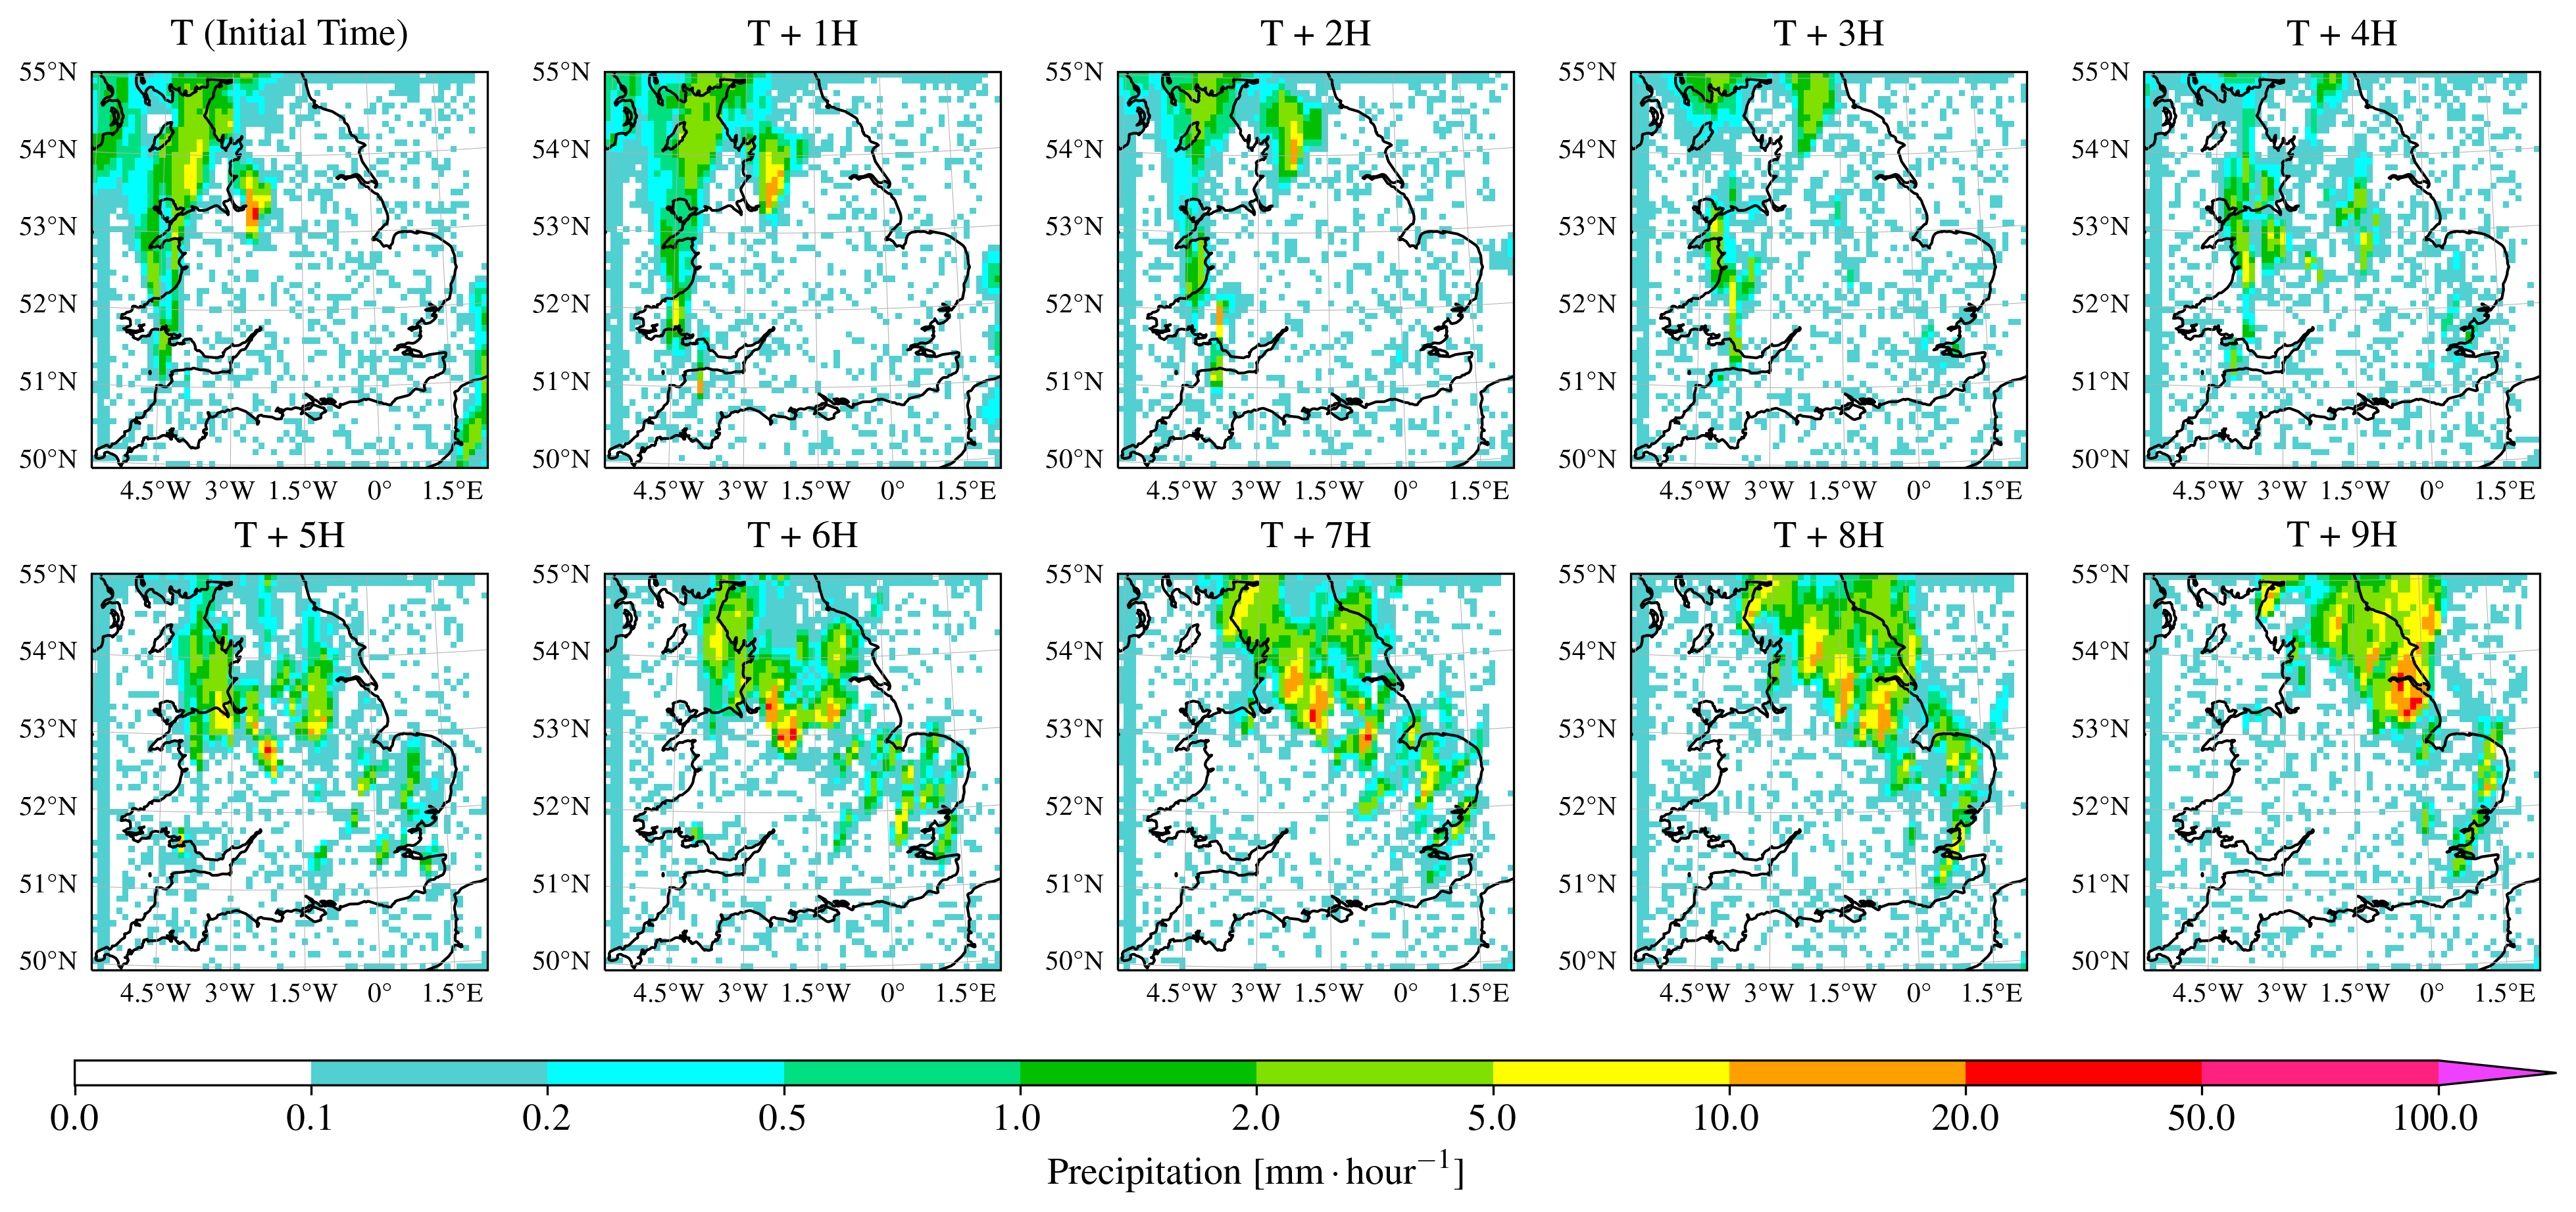

In [22]:
def plot_sample(sample):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=5,
        figsize=(13, 6),
        layout = "constrained",
        subplot_kw={'projection': cp_model_rotated_pole},
    )

    for i, ax in enumerate(axes.flat):
        im = sample.isel(time=i).plot.pcolormesh(
            ax=ax, 
            x = 'longitude', 
            y = 'latitude',
            cmap = precip_cmap,
            norm = precip_norm,
            extend = 'max',
            transform=ccrs.PlateCarree(),
            add_colorbar = False,
        )
        ax.gridlines(linewidth = 0.25, draw_labels={"bottom": "x", "left": "y"}, x_inline=False, y_inline=False)
        ax.coastlines(resolution='10m')
        if i == 0:
            ax.set_title(f"T (Initial Time)", fontsize=14)
        else:
            ax.set_title(f"T + {i}H", fontsize=14)

    cbar = fig.colorbar(
        im, 
        ax = axes, 
        orientation="horizontal", 
        aspect=100, 
        # shrink = 1,
        ticks=precip_clevs,
        label='Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]',
    )

    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label='Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]', size=14)

    plt.savefig("examples/geo.png", bbox_inches='tight', pad_inches=0.2)
    plt.show()

sample = samples[1954][0]

da = xr.DataArray(sample, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
plot_sample(da)

In [15]:
# 10 frames with the highest max and mean values

videos_flattened = samples.reshape(-1, 10 * 64 * 64)
maxes = torch.sort(torch.amax(videos_flattened, dim=1), descending = True)
means = torch.sort(torch.mean(videos_flattened, dim=1), descending = True)

maxes_pairs = [(i.item(), j.item()) for i, j in zip(maxes.indices, maxes.values)]
means_pairs = [(i.item(), j.item()) for i, j in zip(means.indices, means.values)]

print("Max individual cells")
for i in range(200):
    print(f"Index: {maxes_pairs[i][0]}, Value: {maxes_pairs[i][1]:.2f}", end = "    ")

print("\n\nMax mean cells")
for i in range(200):
    print(f"Index: {means_pairs[i][0]}, Value: {means_pairs[i][1]:.2f}", end = "    ")

Max individual cells
Index: 705, Value: 49.15    Index: 607, Value: 42.75    Index: 191, Value: 42.44    Index: 2529, Value: 37.40    Index: 2255, Value: 36.94    Index: 6, Value: 35.58    Index: 979, Value: 34.72    Index: 2850, Value: 33.00    Index: 292, Value: 31.16    Index: 1954, Value: 31.11    Index: 2958, Value: 30.59    Index: 2061, Value: 30.30    Index: 281, Value: 30.20    Index: 2320, Value: 30.16    Index: 945, Value: 29.53    Index: 242, Value: 29.14    Index: 2630, Value: 28.17    Index: 513, Value: 28.12    Index: 523, Value: 27.88    Index: 1810, Value: 27.83    Index: 2651, Value: 27.47    Index: 2454, Value: 27.31    Index: 2292, Value: 27.21    Index: 1878, Value: 26.81    Index: 1987, Value: 26.38    Index: 2510, Value: 26.12    Index: 2244, Value: 25.97    Index: 402, Value: 25.80    Index: 1328, Value: 25.72    Index: 331, Value: 25.63    Index: 1009, Value: 25.61    Index: 1694, Value: 25.46    Index: 286, Value: 25.38    Index: 2224, Value: 25.22    Index: 12

In [261]:
videos_flattened = samples.reshape(-1, 10 * 64 * 64)

element_counts = torch.sum(videos_flattened > 10, axis=1)

# Find the top k largest element counts
k = 20  # Replace with your desired k value
top_k_values, top_k_indices = element_counts.topk(k)

print(top_k_values)
print(top_k_indices)

tensor([331, 322, 315, 314, 255, 215, 215, 210, 188, 185, 160, 153, 150, 131,
        128, 120, 116, 116, 112, 107])
tensor([ 989, 2250,  104, 2415, 1655,  774, 2718,  528, 1890,  125, 1843, 2197,
        2468, 2887, 1705, 3137, 2769, 2651, 2682,  211])
